## Efficient data loaders

In [4]:
from kipoi_cadd.data import CaddDataset
import pyarrow as pa
import blosc
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
lmdb_dir = "/s/project/kipoi-cadd/data/raw/v1.3/training_data/lmdb"
variant_id_file = "/s/project/kipoi-cadd/data/raw/v1.3/training_data/variant_ids.pkl"

In [6]:
ds = CaddDataset(lmdb_dir, variant_id_file)

In [7]:
%%time
plot_data = {'batch_size': [], 'compression_ratio': []}
for i in [32, 64, 128, 256, 512, 1024, 2048]:
    batch = next(ds.batch_train_iter(batch_size=i, num_workers=10))
    buff = pa.serialize(batch).to_buffer()
    blzpacked = blosc.compress(buff, typesize=8, cname='blosclz')
    ratio = round(len(buff) / float(len(blzpacked)), 3)
    plot_data['batch_size'].append(i)
    plot_data['compression_ratio'].append(ratio)

CPU times: user 328 ms, sys: 6.59 s, total: 6.91 s
Wall time: 16.3 s


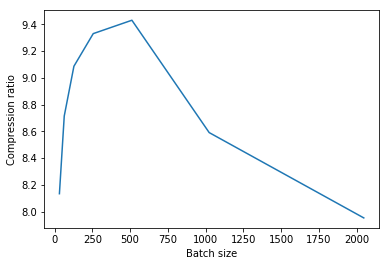

In [8]:
plt.plot(plot_data['batch_size'], plot_data['compression_ratio'])
plt.ylabel('Compression ratio')
plt.xlabel('Batch size')
plt.show()

### Supplementary table

In [15]:
df = pd.DataFrame(plot_data)
df.rename(columns={'batch_size': 'Batch size',
                   'compression_ratio': 'Compression ratio'},
          inplace=True)
df

,Batch size,Compression ratio
0,32,8.134
1,64,8.715
2,128,9.087
3,256,9.331
4,512,9.431
5,1024,8.591
6,2048,7.953


## Batch loading speed

In [7]:
%%time
ds = CaddDataset(lmdb_dir, variant_id_file)

In [18]:
%%time
import time
times = {'init_it': [], 'get_next':[]}
for bs in [32, 64, 128, 256, 512, 1024, 2048]:
    start = time.clock()
    it = ds.batch_iter(batch_size=bs, shuffle=True, num_workers=10)
    end = time.clock()
    times['init_it'].append(end - start)
    
    start = time.clock()
    bla = next(it)
    end = time.clock()
    times['get_next'].append(end - start)
    times['batch_size'].append(bs)

CPU times: user 27.3 s, sys: 26.7 s, total: 54 s
Wall time: 3min 23s


In [20]:
times['batch_size'] = [32, 64, 128, 256, 512, 1024, 2048]

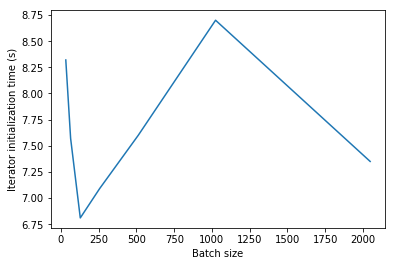

In [21]:
plt.plot(times['batch_size'], times['init_it'])
plt.ylabel('Iterator initialization time (s)')
plt.xlabel('Batch size')
plt.show()

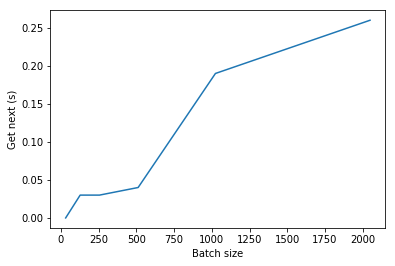

In [23]:
plt.plot(times['batch_size'], times['get_next'])
plt.ylabel('Get next (s)')
plt.xlabel('Batch size')
plt.show()

In [26]:
it = ds.batch_train_iter(batch_size=64, shuffle=True, num_workers=10)
x, y = next(it)
x, y

(array([[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]]),
 array([0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
        1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1.,
        0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1.]))